# Quantum Phase Estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

## Quantum Circuit for Phase Estimation 

The general quantum circuit for phase estimation is:
<img src="images/qpe_tex_qz.png">

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

0. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form an ancilla register: 

$$ \psi_0 = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$ 

1. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the ancilla register: 

$$ \psi_1 = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$

2. **Controlled Unitary Operations**: We need to introduce the controlled unitary $C-U$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operatory with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: 

$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$

Applying all the $n$ controlled operations $C − U^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

\begin{aligned}
\psi_{2} & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
where $k$ denotes the integer representation of n-bit binary numbers. 

3. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform as we derived in the notebook on [Quantum Fourier Transform and its Qiskit Implementation](qft.ipynb). Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the ancilla register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$ 

4. **Measurement**: 
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the ancilla register with high probability: 

$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$

For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$ [1].

## Example

Consider a 3-qubit quantum phase estimation of a one-qubit state $\vert\psi\rangle$.

For this example, let us take the unitary matrix to be $Z$. Then, the input state $\vert1\rangle$ is an eigenvector with eigenvalue $-1 = \exp{\left(2\pi i \times 0.5 \right)}$. Hence, $\theta = 0.5$ and $2^n\theta = 2$ if we use $n = 2$ ancilla qubits. 

Note that in this case, the controlled unitary gates are

$$
U^{2^{n-1}} = Z^2 = I
$$
and 
$$
U^{2^{0}} = Z
$$

## Qiskit Implementation 1

Now we will implement the above example in Qiskit.

Let's first prepare our environment.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

Now, set up the quantum circuit. We will use three qubits -- qubits 0 and 1 as ancilla, and qubit 2 as the eigenstate of the unitary operator. 

We initialize $\vert\psi\rangle = \vert1\rangle$ by applying an $X$ gate.

In [2]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.x(q[2])

Next, we apply Hadamard gates to the ancilla qubits.

In [3]:
qpe.h(q[0])
qpe.h(q[1])

Next we perform the controlled unitary operations:

In [4]:
# controlled unitary from q[0] is the identity matrix

# controlled unitary from q[1] is a controlled-Z gate
qpe.cz(q[1], q[2]);

We apply quantum inverse Fourier transformation to write the phase to the ancilla register. We will use exactly the code that we wrote to do a $QFT$ and adapt it to be that of $QFT^\dagger$.

In [5]:
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(math.pi/float(2**(k-j)), q[k], q[j])
            
def qft_dagger(circ, q, n):
    """n-qubit QFTdagger on q in circ."""
    for j in range(n):
        k = (n-1) - j
        for m in range(k):
            circ.cu1(-math.pi/float(2**(k-m)), q[k], q[m])
        circ.h(q[k])

We then measure the ancilla register:

In [6]:
qft_dagger(qpe, q, 2)

qpe.measure(q[0],c[0])
qpe.measure(q[1],c[1])

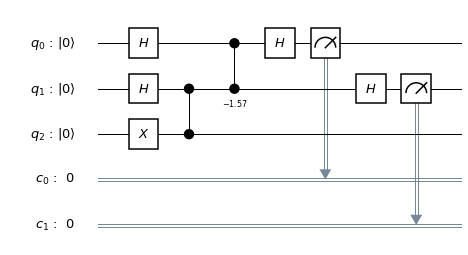

In [7]:
qpe.draw(output="mpl")

## Qiskit Implementation 2

This time, we will see what happens to our estimate of the phase by using more ancilla qubits. Let's go from two ancilla to three, and from a one-qubit state to a two-qubit state. The unitary operator will be $U = C-Z$. Then, for state $\vert11\rangle$, we get a phase of $\theta = 0.5$. We will implement a C-U gate (C-C-Z) from a C-C-X gate (Toffoli) by using the relation 

$$
HXH = Z
$$

First, we set up the quantum circuit as before. We initialize $\vert\psi\rangle = \vert11\rangle$ by applying an $X$ gate to both qubits.

In [8]:
nancilla = 4
q2 = QuantumRegister(nancilla+2, 'q')
c2 = ClassicalRegister(nancilla, 'c')

qpe2 = QuantumCircuit(q2, c2)
qpe2.x(q2[nancilla])
qpe2.x(q2[nancilla+1])

Again, we apply Hadamard gates to the ancilla qubits.

In [9]:
for i in range(nancilla):
    qpe2.h(q2[i])

Next we perform the controlled unitary operations:

In [10]:
# controlled unitary from q[0] is the identity matrix
# controlled unitary from q[1] is the identity matrix
# controlled unitary from q[2] is a controlled-Z gate
qpe2.h(q2[nancilla+1])
qpe2.ccx(q2[nancilla-1], q2[nancilla], q2[nancilla+1])
qpe2.h(q2[nancilla+1])


As before, we apply an inverse quantum Fourier transform to write the phase to the ancilla register. We then measure the ancilla register.

In [11]:
qft_dagger(qpe2, q2, nancilla)

for i in range(nancilla):
    qpe2.measure(q2[i],c2[i])

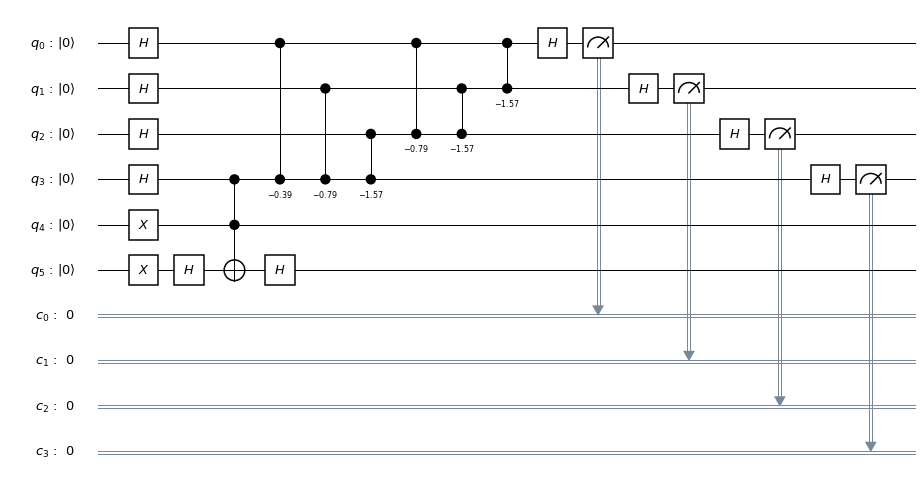

In [12]:
qpe2.draw(output="mpl")

## Experiment with Simulators

We can run the above circuit on the simulator. 

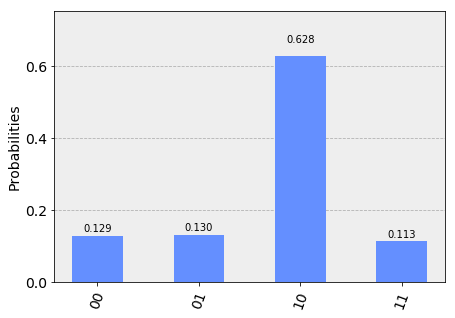

In [13]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

We indeed see a peak at the binary representation of $2^n\theta = 2^2\times0.5 = 2$ (10).

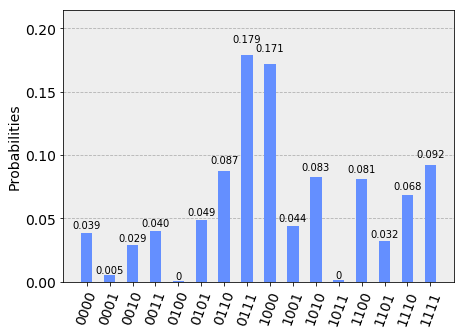

In [14]:
results2 = execute(qpe2, backend=backend, shots=shots).result()
answer2 = results2.get_counts()
plot_histogram(answer2)

We indeed see a peak at the binary representation of $2^n\theta = 2^4\times0.5 = 8$ (1000).

## Experiment with Real Devices

We can run the circuit for our three-qubit implementation of quantum phase estimation on the real device as shown below.

In [15]:
# Load our saved IBMQ accounts and get the least busy backend device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-internal, yrk, main)>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(ibm-q-internal, yrk, main)>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ(ibm-q-internal, yrk, main)>]

In [16]:
backend = provider.get_backend('ibmq_vigo')
from qiskit.tools.monitor import job_monitor
shots = 2048
job_exp = execute(qpe, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

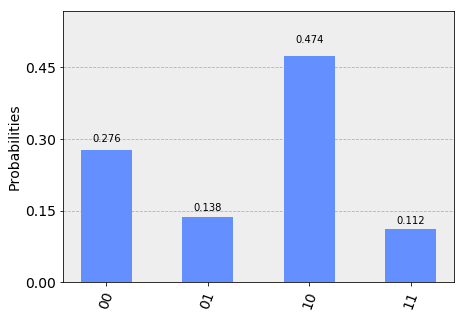

In [17]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(qpe)
plot_histogram(answer)

## References

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA. 